# Kaggle Notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [2]:
import torch
import torchvision

## Read the csv image data train and test using pandas

In [3]:
train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

In [4]:
train_data.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_data.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0


### Explore some features of the dataset


In [6]:
print(train_data.columns)
print(test_data.columns)
print(train_data.shape)
print(test_data.shape)
# excluding the label column
print(f"Min value of train dataset is {train_data.iloc[0].min()}\nMin value of test dataset is {test_data.iloc[0].min()}")
print(f"Max value of train dataset is {train_data.iloc[0].max()}\nMax value of test dataset is {test_data.iloc[0].max()}")

Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)
Index(['label', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=785)
(60000, 785)
(10000, 785)
Min value of train dataset is 0
Min value of test dataset is 0
Max value of train dataset is 255
Max value of test dataset is 255


## Preprocess the data 
* Normalise values to be in range [0-1]
* Convert the image to be in shape 28, 28 for our model

In [7]:
def preprocess(data):
    images = data.iloc[:, 1:]/255
    labels = data['label']
    return images, labels
    
train_images, train_labels = preprocess(train_data)
test_images, test_labels = preprocess(test_data)

In [8]:
# after preprocessing
print(train_images.columns)
print(test_images.columns)
print(train_images.shape)
print(test_images.shape)
# excluding the label column
print(f"Min value of train dataset is {train_images.iloc[0].min()}\nMin value of test dataset is {test_images.iloc[0].min()}")
print(f"Max value of train dataset is {train_images.iloc[0].max()}\nMax value of test dataset is {test_images.iloc[0].max()}")

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)
Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)
(60000, 784)
(10000, 784)
Min value of train dataset is 0.0
Min value of test dataset is 0.0
Max value of train dataset is 1.0
Max value of test dataset is 1.0


In [12]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(30, 70)),
])


In [13]:
def dataloader(data, labels, batch_size=64, train=True):
    if data.shape[0] == len(labels):
        for i in range(0, data.shape[0], batch_size):
            batch_data = []
            batch_labels = []
            for j in range(i, min(i+batch_size, data.shape[0])):
                image_data = torch.tensor([im for im in data.iloc[j,:]], dtype=torch.float).reshape(28,28)
                if train==True:
                    transformed_image = train_transform(image_data.unsqueeze(dim=0)).squeeze()
                    batch_data.append(transformed_image)
                else:
                    batch_data.append(torch.tensor(image_data, dtype=torch.float))
                batch_labels.append(torch.tensor(labels.iloc[j]))
            # yield torch.tensor(batch_data), batch_labels   
            yield torch.cat([x.unsqueeze(0) for x in batch_data]), torch.tensor(batch_labels)


In [14]:
train_dataloader = dataloader(train_images, train_labels, train=False)
test_dataloader = dataloader(test_images, test_labels, train=False)


In [15]:
# Convert the dataloader to a list
train_dataloader = list(train_dataloader)
test_dataloader = list(test_dataloader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [16]:
# def calculate_dataloader_size(data_loader):
#     count=0
#     while True:
#         try:
#             next(data_loader)
#             count+=1
#         except Exception as e:
#             break
#     print(f"size of {data_loader} is {count}")

# calculate_dataloader_size(train_dataloader)
# calculate_dataloader_size(test_dataloader)

# View Images

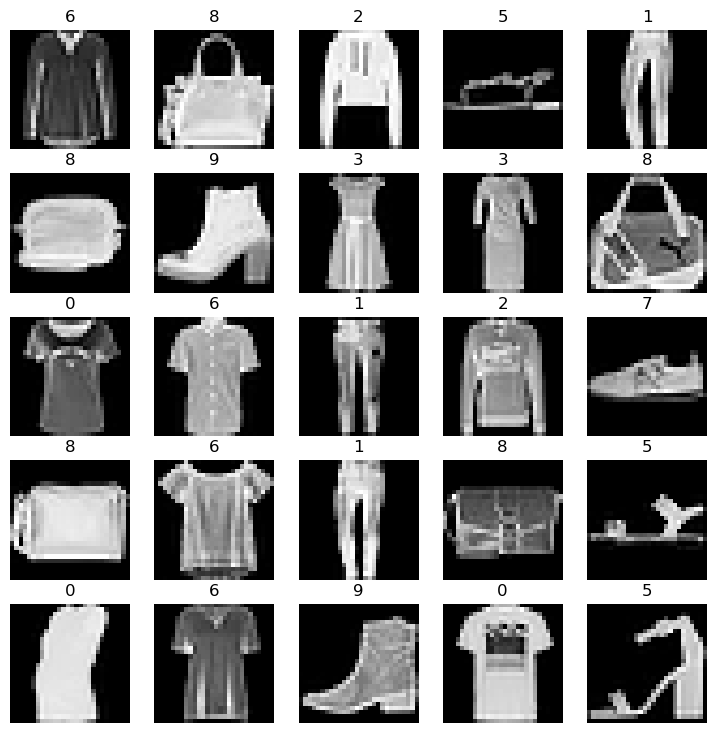

In [17]:
import torch
import matplotlib.pyplot as plt
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 5, 5
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_dataloader), size=[1]).item()
    random_idx1 = torch.randint(0, 64, size=[1]).item()
    img, label = train_dataloader[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img[random_idx1].squeeze(), cmap="gray")
    plt.title(label[random_idx1].item())
    plt.axis(False);

# CNN

In [18]:
import torch
import torch.nn as nn

In [51]:
class FashionMNISTModelV1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=84, kernel_size=5, stride=1, padding=1),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=84, out_channels=100, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.block5 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1600, out_features=10),
            nn.Softmax(dim=1)
        )
       

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = FashionMNISTModelV1().to(device)  

In [54]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [64]:
# setup loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(params=model_1.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [65]:
from timeit import default_timer as time
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    "prints difference between start and end time"

    total_time = end-start
    print(f"Train time on {device} : {total_time: .3f} seconds")
    return total_time

In [66]:
for x, y in train_dataloader:
    print(type(x))
    break

<class 'torch.Tensor'>


In [67]:
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_time_start_on_cpu = time() 

# Set the number of epochs (we'll keep this small for faster training time)
epochs = 5
# Create training and test loop
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}\n------")
    ### Training
    train_loss = 0
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(tqdm(train_dataloader)):
        model_1.train()
#         X, y = torch.tensor(X, dtype=torch.float), torch.tensor(y)

        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model_1(X.unsqueeze(dim=1))

    
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate train loss
    
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step (update the model's parameters once *per batch*)
        optimizer.step()

        # Print out what's happening
        # if batch % 400 == 0:
        #     print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_1.eval()
    with torch.inference_mode(): 
        for X_test, y_test in test_dataloader:
            # 1. Forward pass
#             X_test, y_test = torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test)
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model_1(X_test.unsqueeze(dim=1))

            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y_test)

            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Calculate the test loss average per batch
        test_loss /= len(test_dataloader)

        # Calculate the test acc average per batch
        test_acc /= len(test_dataloader)

    # Print out what's happening
    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = time()
total_train_time_model_1 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_1.parameters()).device))


Epoch: 1
------


  0%|          | 0/938 [00:00<?, ?it/s]


Train loss: 1.5885 | Test loss: 1.5955, Test acc: 86.7436
Epoch: 2
------


  0%|          | 0/938 [00:00<?, ?it/s]


Train loss: 1.5883 | Test loss: 1.5953, Test acc: 86.7536
Epoch: 3
------


  0%|          | 0/938 [00:00<?, ?it/s]


Train loss: 1.5882 | Test loss: 1.5953, Test acc: 86.7735
Epoch: 4
------


  0%|          | 0/938 [00:00<?, ?it/s]


Train loss: 1.5882 | Test loss: 1.5952, Test acc: 86.7735
Epoch: 5
------


  0%|          | 0/938 [00:00<?, ?it/s]


Train loss: 1.5881 | Test loss: 1.5952, Test acc: 86.7834
Train time on cuda:0 :  23.563 seconds


In [68]:
torch.save(model_1, "FashionMnist1.pt")

In [93]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_1.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_1(X.unsqueeze(dim=1))

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/157 [00:00<?, ?it/s]

tensor([0, 1, 2,  ..., 8, 8, 2])

In [104]:
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth
print(len(test_preds))
print(len(test_truth))
print(test_preds.shape, test_truth.shape)

10000
10000
torch.Size([10000]) torch.Size([10000])


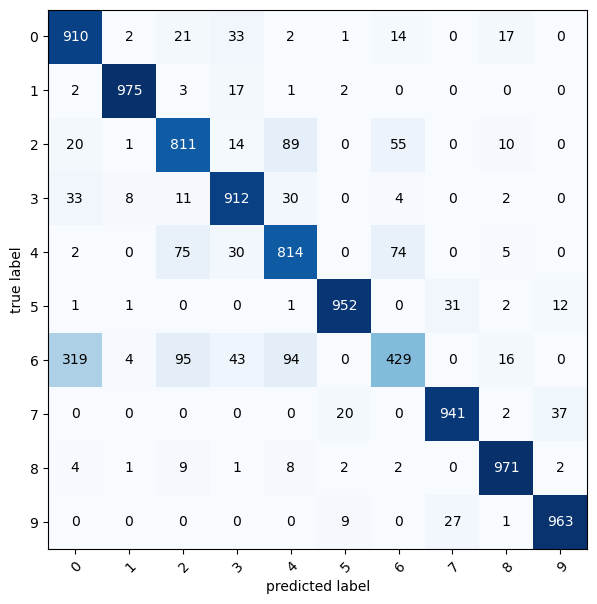

In [108]:

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
class_name = [0,1,2,3,4,5,6,7,8,9]
# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_name) ,task="multiclass")
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_name,
    figsize=(10, 7)
)